# Iterating $Y_n$ and $B_\theta$ 
$Y_n$'s free component depends on $B_\theta$, and the rest of $Y_n$ and $B_\theta$ depends on that free component. It's troublesome to find a way to self-consistently solve for all components of $Y_n$. That will make 2n coupled 1st order linear ODE's. Instead we attempt to solve for Yn0 or Yn1c by iteration

$Y$'s non-free components can be solved for like B_theta since the convolution matrix is of a similarly simple form.
However, $B_{\theta n-1}$'s dependence on $Y_{n-1}$'s undetermined components, especially Yn1c, is tricky. Yn0 only appears in the center two components of the looped equation, and would not impact $B_\theta$, but Yn1c' and Yn1c'' appears at the center element and in one off-center element.
This makes it very tricky to handle.

In [1]:
# This file implements and tests recursion relations
import numpy as np
import timeit
import scipy.signal
from matplotlib import pyplot as plt
from numba import jit, njit, prange
from numba import complex128, int64    # import jit value types
from functools import lru_cache # import functools for caching
import warnings

# for importing parsed codes
import sys
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/parsed/')
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/')
from chiphifunc import *
from math_utilities import *
from chiphiepsfunc import *
from chiphifunc_test_suite import *
from recursion_relations_full import *
debug_path = '/Users/lanke/Desktop/Second year project/Code/test_data_eduardo/'

Detected 16 CPU's. Setting n_jobs to #CPU/2.


Axis shape:


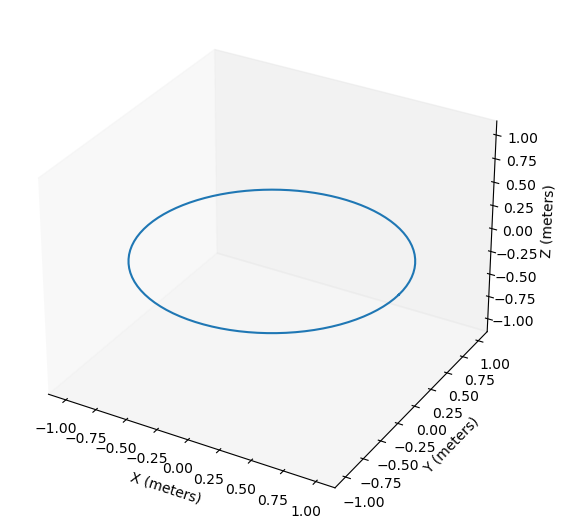

1

In [2]:
# No B theta
# The only case with non-trivial an-isotropic pressure
B_psi_coef_cp, B_theta_coef_cp, \
    Delta_coef_cp, p_perp_coef_cp,\
    X_coef_cp, Y_coef_cp, Z_coef_cp, \
    iota_coef, dl_p,\
    nfp, Xi_0, eta, \
    B_denom_coef_c, B_alpha_coef, \
    kap_p, tau_p = read_first_three_orders(
        debug_path+'circ/', 
        R_array=[2,0,1,2,0.0001,0],
        Z_array=[1,2,0,0.001]
    )
iota_coef.get_order()

In [3]:
test_equilibrium = Equilibrium(X_coef_cp.mask(2),
    Y_coef_cp.mask(2),
    Z_coef_cp.mask(2),
    B_psi_coef_cp.mask(0),
    B_theta_coef_cp.mask(2),
    B_denom_coef_c.mask(2),
    B_alpha_coef.mask(1),
    kap_p, dl_p, tau_p,
    iota_coef.mask(0), eta,
    p_perp_coef_cp.mask(2),
    Delta_coef_cp.mask(2))

p_perp_coef_cp.append(iterate_p_perp_n(3,
    B_theta_coef_cp,
    B_psi_coef_cp,
    B_alpha_coef,
    B_denom_coef_c,
    p_perp_coef_cp,
    Delta_coef_cp,
    iota_coef))
Delta_coef_cp.append(iterate_delta_n(3,
    B_denom_coef_c,
    p_perp_coef_cp,
    Delta_coef_cp,
    iota_coef))

solve_integration_factor: average p_eff: 1.05129704
solve_integration_factor: average f_eff: 0.12055581493791792
integral_mode is spline


## Testing Yn1c solver

solve_integration_factor: average p_eff: 11.375539862871188
solve_integration_factor: average f_eff: 112.10226731623551
integral_mode is asymptotic
Optimum truncation at order 2
Amplitude of the truncation term: [4.70839457 4.70839457]
solve_integration_factor: average p_eff: 0.13401251941451686
solve_integration_factor: average f_eff: 484.28114496162806
integral_mode is spline
I(phi) is periodic. Cannot yield an unique solution using only periodic BC.
returning integration factor.


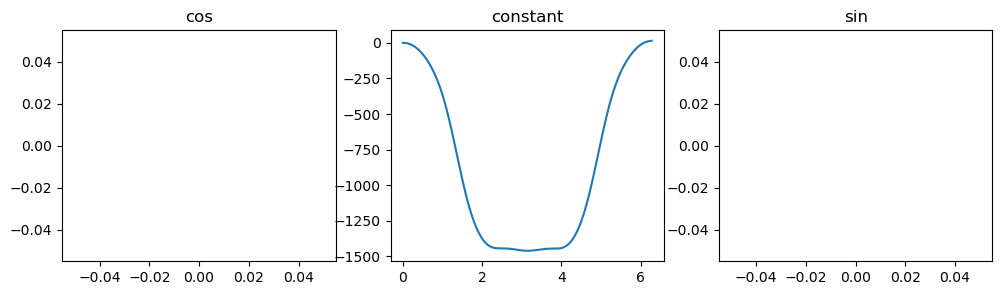

avg RHS (-0.09030955217649389+1.6643858920210917e-19j)
exp_factor_neg
A


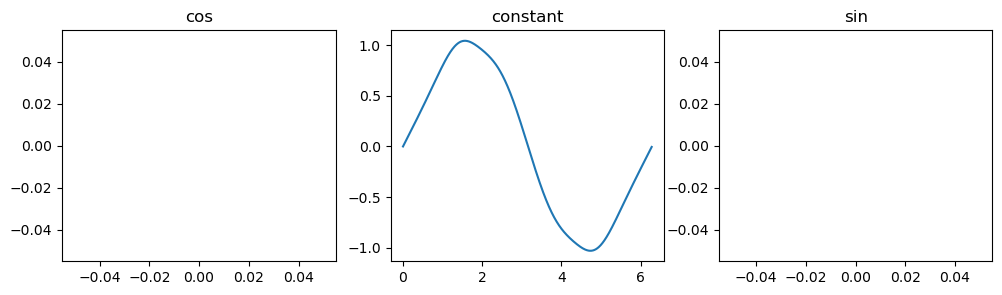

B


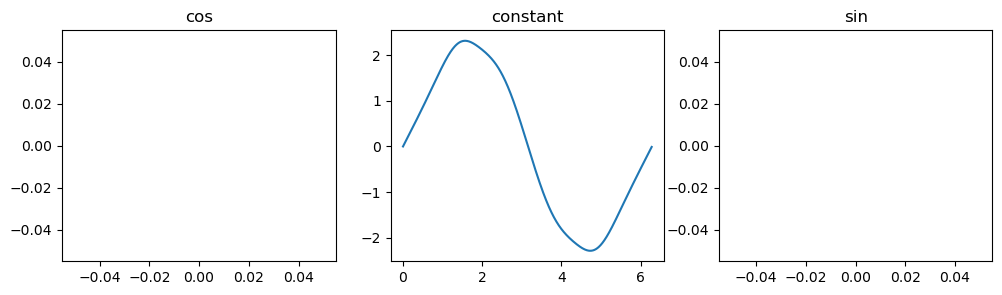

Difference


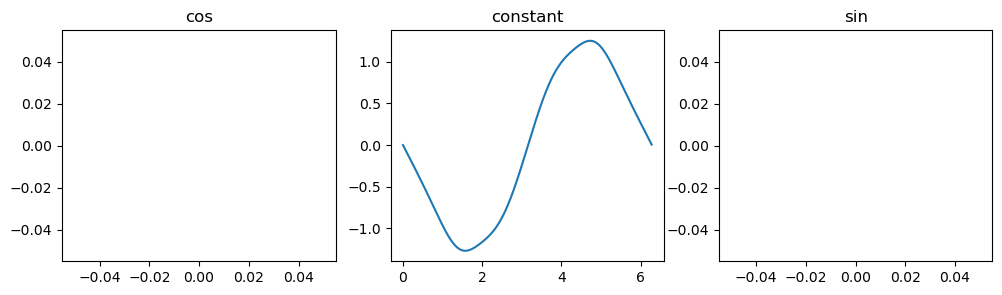

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             7.844e-01      
Worst:          5.579e-01       1.269e+00      
Std             nan             3.904e-01      
Total imaginary component
0.0



/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  A_content_padded[a_pad_row:shape[0]-a_pad_row,a_pad_col:shape[1]-a_pad_col] = A.content
/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:97: ComplexWarning: Casting complex values to real discards the imaginary part
  B_content_padded[b_pad_row:shape[0]-b_pad_row,b_pad_col:shape[1]-b_pad_col] = B.content
/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:105: RuntimeWarning: invalid value encountered in true_divide
  frac = np.abs((guess-ans)/ans)


In [4]:
B_theta_3, loop_suppressing_B_theta_3 = iterate_B_theta_nm1_cp(4,
    X_coef_cp, Y_coef_cp, Z_coef_cp,
    B_theta_coef_cp, B_psi_coef_cp,
    B_alpha_coef, B_denom_coef_c,
    p_perp_coef_cp,
    Delta_coef_cp,
    kap_p, dl_p, tau_p, iota_coef,
    test_equilibrium.coeff_B_theta_nm1, # test_equilibrium.coeff_B_theta_nm1
    test_equilibrium.coeff_dc_B_theta_nm1,
    test_equilibrium.coeff_dp_B_theta_nm1,
    'asymptotic', B_theta_n0=0)
B40 = test_equilibrium.iterate_B_theta_n0_cp(loop_suppressing_B_theta_3, B_theta_3)

B40.display_content()
Y31c,_ = iterate_Yn1c_p(3, X_coef_cp, Y_coef_cp, Z_coef_cp,\
                  iota_coef,\
                  tau_p, dl_p, kap_p, eta,\
                  B_denom_coef_c, B_alpha_coef,
                  B_psi_coef_cp, B_theta_coef_cp, 0)


Y31s_p, Y31c_p = Y_coef_cp[3].get_Yn1s_Yn1c()
compare_chiphifunc(Y31c, Y31c_p, simple_mode = False)

## Iterating for odd Y

In [101]:
# Even order
n_eval = 3

# We try estimate Yn1c with Halley's method (function has local minima). abbreviate Yn1c as y.
# Yn1c_guess(y) = y, where Yn1c_guess is a loop through Y and B_theta.
# F(y) = Yn1c_guess(y) - y = 0
# F'(y) = Yn1c_guess'(y) - 1
# y_new = y_old - F(y_old)/F
def newton_iterate(Yn1c_prev):
    F, Yn_old, B_theta_old = Yn1c_guess(Yn1c_prev) 
    F = F - Yn1c_prev
    
    if np.isscalar(Yn1c_prev):
        dy = np.abs(Yn1c_prev)/100 + 0.01
    else:
        dy = np.abs(Yn1c_prev.content)/100 + 0.01
    Fp,_,_ = Yn1c_guess(ChiPhiFuncGrid(Yn1c_prev.content+dy))
    # Fn,_,_ = Yn1c_guess(ChiPhiFuncGrid(Yn1c_prev.content-dy))
    dFdyp = (Fp-F).content/dy-1
    # dFdyn = (F-Fn).content/dy-1
    # d2Fdy = (dFdyp-dFdyn)/dy
    
    # return(Yn1c_prev - ChiPhiFuncGrid(
    #     2*F.content*dFdyp/(2*dFdyp**2 - F.content*d2Fdy)
    # ).filter('roll_avg'), Yn_old, B_theta_old )
    print('dFdyp')
    ChiPhiFuncGrid(dFdyp).display_content()
    print('ChiPhiFuncGrid(F.content/dFdyp)')
    ChiPhiFuncGrid(
        F.content/dFdyp
    ).display_content()
    
    return(Yn1c_prev - ChiPhiFuncGrid(
        F.content/dFdyp
    ).filter(), Yn_old, B_theta_old )

def seacant_iterate(Yn1c_prev, Yn1c_prev_prev, F_prev):
    F, Yn_old, B_theta_old = Yn1c_guess(Yn1c_prev) 
    F = F - Yn1c_prev
    
    return(Yn1c_prev - ChiPhiFuncGrid(
        F.content*(Yn1c_prev - Yn1c_prev_prev).content/dFdyp
    ).filter(), Yn_old, B_theta_old )


def Yn1c_guess(Yn1c):
    
    Y_temp = Y_coef_cp.mask(n_eval-1)
    B_theta_temp = B_theta_coef_cp.mask(n_eval-1)
    
    Yn_zero_yn1c = iterate_Yn_cp(n_eval,
        X_coef_cp,
        Y_temp,
        Z_coef_cp,
        B_psi_coef_cp,
        B_theta_temp,
        B_alpha_coef,
        kap_p, dl_p, tau_p,
        iota_coef,
        Yn1c*0.5)

    Y_temp.append(Yn_zero_yn1c)


    B_theta_n, loop_suppressing_B_theta_nm1 = iterate_B_theta_nm1_cp(4,
    X_coef_cp, Y_temp, Z_coef_cp,
    B_theta_temp, B_psi_coef_cp,
    B_alpha_coef, B_denom_coef_c,
    p_perp_coef_cp,
    Delta_coef_cp,
    kap_p, dl_p, tau_p, iota_coef,
    test_equilibrium.coeff_B_theta_nm1, # test_equilibrium.coeff_B_theta_nm1
    test_equilibrium.coeff_dc_B_theta_nm1,
    test_equilibrium.coeff_dp_B_theta_nm1,
    'double_spline', B_theta_n0=0)


    B_theta_temp.append(B_theta_n)

    Bnp10 = test_equilibrium.iterate_B_theta_n0_cp(loop_suppressing_B_theta_nm1, B_theta_n)

    Yn1c_new,_ = iterate_Yn1c_p(n_eval, X_coef_cp, Y_temp, Z_coef_cp,\
                  iota_coef,\
                  tau_p, dl_p, kap_p, eta,\
                  B_denom_coef_c, B_alpha_coef,
                  B_psi_coef_cp, B_theta_temp, Bnp10)
    return(Yn1c_new, Y_temp, B_theta_temp)

solve_integration_factor: average p_eff: 11.375539862871188
solve_integration_factor: average f_eff: 120.38815399060891
integral_mode is double_spline
solve_integration_factor: average p_eff: 11.375539862871188
solve_integration_factor: average f_eff: 120.38815399060891
integral_mode is asymptotic
Optimum truncation at order 1
Amplitude of the truncation term: [22.36418255 22.36418255]
solve_integration_factor: average p_eff: 0.13401251941451686
solve_integration_factor: average f_eff: 325.16384951995633
integral_mode is spline
I(phi) is periodic. Cannot yield an unique solution using only periodic BC.
returning integration factor.
avg RHS (41.48038104775605-1.4064627861744335e-11j)
exp_factor_neg


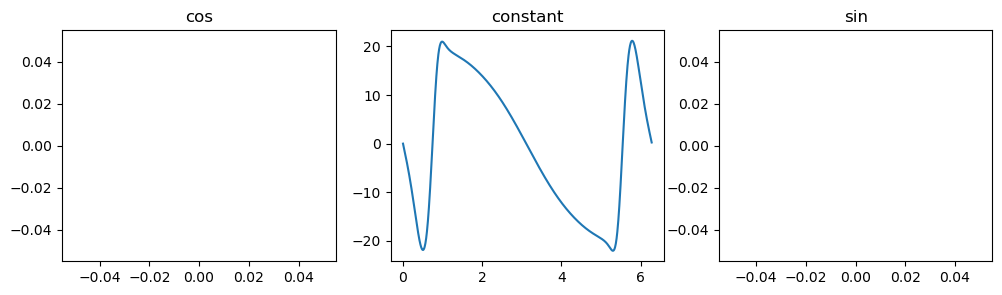

In [102]:

guess,_,_ = Yn1c_guess(Y31c_p)
guess.display_content()

solve_integration_factor: average p_eff: 11.375539862871188
solve_integration_factor: average f_eff: 2709.5458768452013
integral_mode is double_spline
solve_integration_factor: average p_eff: 11.375539862871188
solve_integration_factor: average f_eff: 2709.5458768452013
integral_mode is asymptotic
Optimum truncation at order 1
Amplitude of the truncation term: [8167.07715701 8167.07715701]
solve_integration_factor: average p_eff: 0.13401251941451686
solve_integration_factor: average f_eff: 173.46046181699114
integral_mode is spline
I(phi) is periodic. Cannot yield an unique solution using only periodic BC.
returning integration factor.
avg RHS (-1.8040686624862876+3.666326232884842e-11j)
exp_factor_neg
solve_integration_factor: average p_eff: 11.375539862871188
solve_integration_factor: average f_eff: 2698.6204293521378
integral_mode is double_spline
solve_integration_factor: average p_eff: 11.375539862871188
solve_integration_factor: average f_eff: 2698.6204293521378
integral_mode is 

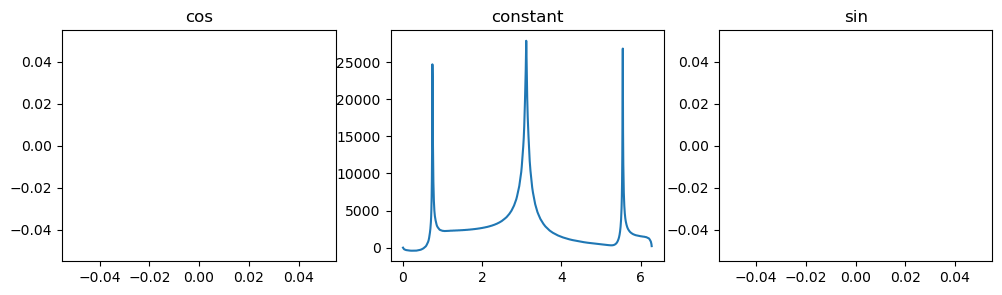

ChiPhiFuncGrid(F.content/dFdyp)


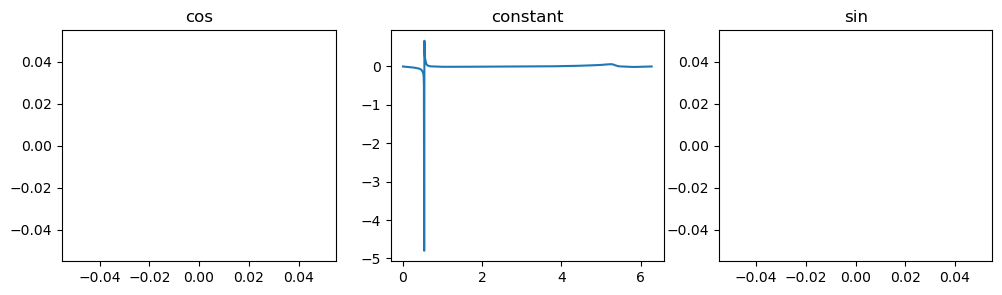

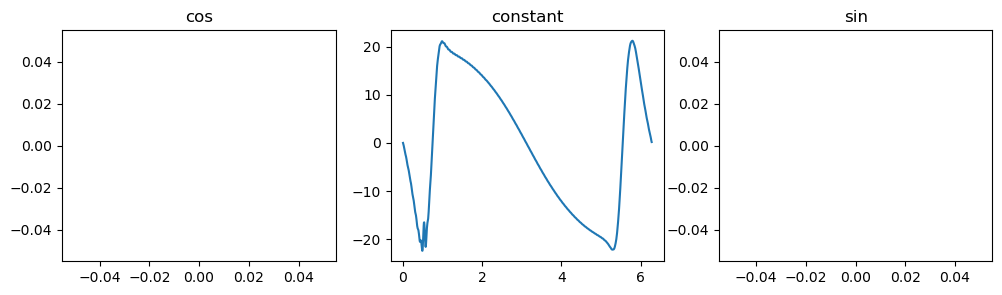

solve_integration_factor: average p_eff: 11.375539862871188
solve_integration_factor: average f_eff: 3234.641845656191
integral_mode is double_spline
solve_integration_factor: average p_eff: 11.375539862871188
solve_integration_factor: average f_eff: 3234.641845656191
integral_mode is asymptotic
Optimum truncation at order 1
Amplitude of the truncation term: [10111.34635995 10111.34635995]
solve_integration_factor: average p_eff: 0.13401251941451686
solve_integration_factor: average f_eff: 209.40171196324744
integral_mode is spline
I(phi) is periodic. Cannot yield an unique solution using only periodic BC.
returning integration factor.
avg RHS (1.2175731150548013+1.2539175887482173e-10j)
exp_factor_neg
guess-fguess


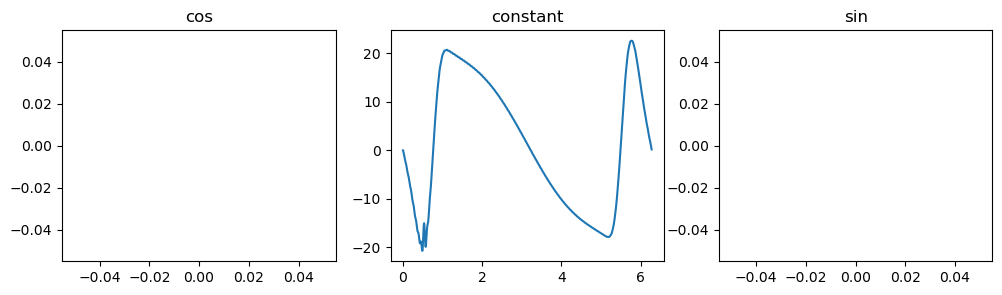

In [106]:
guess_prev = guess
guess,_,_ = iterate(guess)
guess.display_content()
f_guess,_,_ = Yn1c_guess(guess)
print('guess-fguess')
(guess - f_guess).display_content()

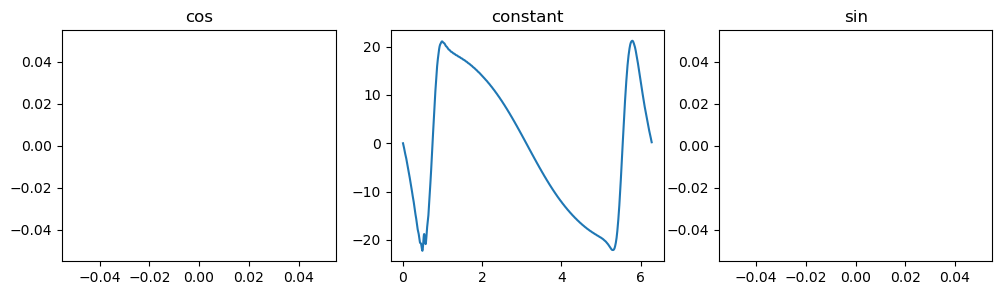

In [104]:
guess.filter().display_content()
